# Imports

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

# Functions

In [97]:
def find_interpolation_range(x, y):
    x_index_init = None
    x_index_final = None
    changed_flag = 0
    for i in range(len(y) - 1):
        if y[i+1] != y[i] and changed_flag == 0: # find lowest x value where there is a change in y
            x_index_init = i
            changed_flag = 1
        if y[i+1] == y[i] and changed_flag == 1: # case where penultimate y value equals final value
            x_index_final = i + 1
            return x_index_init, x_index_final
    
    if x_index_init != None: # case where penultimate value not equal to final value
        x_index_final = len(x)
        return x_index_init, x_index_final
    
    return 0, len(x) # case where all y values are the same
    


In [98]:
def find_FATT_index(interpolated_T, interpolated_C):
    for i in range(len(interpolated_C) - 1):
        if interpolated_C[i] > 50 and interpolated_C[i + 1] < 50:
            return i
    return None

In [99]:
def find_min_max(output_array):
    range = max(output_array) - min(output_array)
    range_fraction = 0.2
    av_min = np.average([y for y in output_array if (y - min(output_array)) < range_fraction * range])
    av_max = np.average([y for y in output_array if (max(output_array) - y) < range_fraction * range])
    return av_min, av_max

In [100]:
def clip_polynomial_array_y(av_min, av_max, polynomial_array):
    for polynomial_index in range(len(polynomial_array)):
        polynomial_point = polynomial_array[polynomial_index]
        if polynomial_point > av_max:
            polynomial_array[polynomial_index] = av_max
        elif polynomial_point < av_min:
            polynomial_array[polynomial_index] = av_min
    return polynomial_array

In [101]:
def clip_polynomial_array_x(av_min, av_max, polynomial_output_array):
    polynomial_output_array[:100] = av_min
    polynomial_output_array[-100:] = av_max
    return polynomial_output_array

In [102]:
def find_TT_index(av_min, av_max, polynomial_input_array, polynomial_output_array):
    TT_impact_energy = (av_min  + av_max) / 2
    for i in range(len(polynomial_output_array)):
        if polynomial_output_array[i] > TT_impact_energy:
            return i

In [139]:
def find_NDT_index(av_min, av_max, polynomial_input_array, polynomial_output_array):
    for i in range(len(polynomial_output_array)):
        if polynomial_output_array[i] > av_min:
            return i

In [131]:
def find_FATT_index(av_min, av_max, polynomial_input_array, polynomial_output_array):
    FATT_percentage_crystallinity = 50
    for i in range(len(polynomial_output_array)):
        if polynomial_output_array[i] < FATT_percentage_crystallinity:
            return i
    return None

In [149]:
def plot_graphs(x, y, isCharpy, axis_index, is_Aluminium_or_Zinc):
    p3 = np.poly1d(np.polyfit(x, y,3))
    polynomial_input_array = np.linspace(x[0], x[len(x) - 1], 1000)

    av_min, av_max = find_min_max(y)
    polynomial_output_array = clip_polynomial_array_y(av_min, av_max, p3(polynomial_input_array))
    if isCharpy:
        BDTT_index = find_TT_index(av_min, av_max, polynomial_input_array, polynomial_output_array)
        NDT_index = find_NDT_index(av_min, av_max, polynomial_input_array, polynomial_output_array)
        polynomial_output_array = clip_polynomial_array_x(av_min, av_max, polynomial_output_array)
        if not is_Aluminium_or_Zinc:
            axs[axis_index].scatter(polynomial_input_array[NDT_index], polynomial_output_array[NDT_index], s = [100], label='Estimated NDT', color='red')
            axs[axis_index].text(0.2, 0.3, f'NDT: {np.round(polynomial_input_array[NDT_index],1)} degrees Celsius', horizontalalignment='center', verticalalignment='center', transform=axs[axis_index].transAxes)
    else:
        BDTT_index = find_FATT_index(av_min, av_max, polynomial_input_array, polynomial_output_array)

    axs[axis_index].scatter(polynomial_input_array, polynomial_output_array, s=[1 for s in range(len(polynomial_input_array))], label='Trendline', color='blue')
    axs[axis_index].scatter(x, y, linewidth=2, label='Measured Values', color='orange')
    if not is_Aluminium_or_Zinc:
        axs[axis_index].scatter(polynomial_input_array[BDTT_index], polynomial_output_array[BDTT_index], s = [100], label='Estimated BDTT', color='green')
        axs[axis_index].text(0.2, 0.4, f'BDTT: {np.round(polynomial_input_array[BDTT_index],1)} degrees Celsius', horizontalalignment='center', verticalalignment='center', transform=axs[axis_index].transAxes)
    axs[axis_index].legend(loc='upper right')


# Crystallinity

C:\Users\Charlie\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Charlie\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


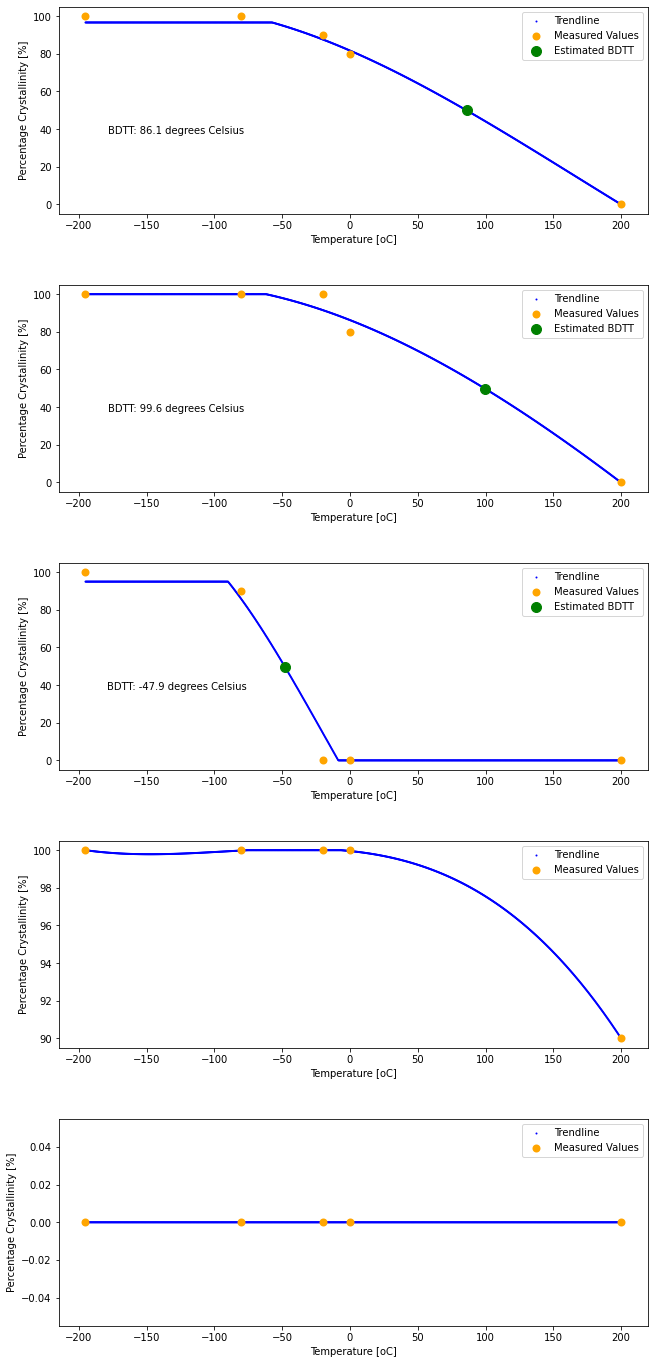

In [150]:
Temperature = [200, 0, -20, -80, -195][::-1]

crystallinity_dict = {'Steel Cold Rolled': [0, 80, 90, 100, 100][::-1], 'Steel Annealed': [0, 80, 100, 100, 100][::-1], 'Steel Normalised': [0, 0, 0, 90, 100][::-1], 'Zinc': [90, 100, 100, 100, 100][::-1], 'Aluminium': [0, 0, 0, 0, 0][::-1]}

fig, axs = plt.subplots(5, 1, figsize=(10,20))
fig.tight_layout(pad=5)
axis_index = 0
for metal in crystallinity_dict:

    x = Temperature
    y = crystallinity_dict[metal]

    if metal == 'Aluminium' or metal == 'Zinc':
        plot_graphs(x, y, False, axis_index, True)
    else:
        plot_graphs(x, y, False, axis_index, False)

    axs[axis_index].set(xlabel='Temperature [oC]', ylabel='Percentage Crystallinity [%]')

    axis_index += 1

plt.show()


# Energy

In [106]:
zn = pd.read_csv('zn.csv')
al = pd.read_csv('al.csv')
annealed = pd.read_csv('annealed.csv')
normalised = pd.read_csv('normalised.csv')
cold_rolled = pd.read_csv('cold_rolled.csv')

In [107]:
al

,Temperature (°C),Average (J)
0,-80,26.83
1,-20,25.00
2,0,26.00
3,20,26.17
4,200,32.00


In [108]:
energy_dict = {'Steel Cold Rolled': cold_rolled, 'Steel Annealed': annealed, 'Steel Normalised': normalised, 'Zinc': zn, 'Aluminium': al}

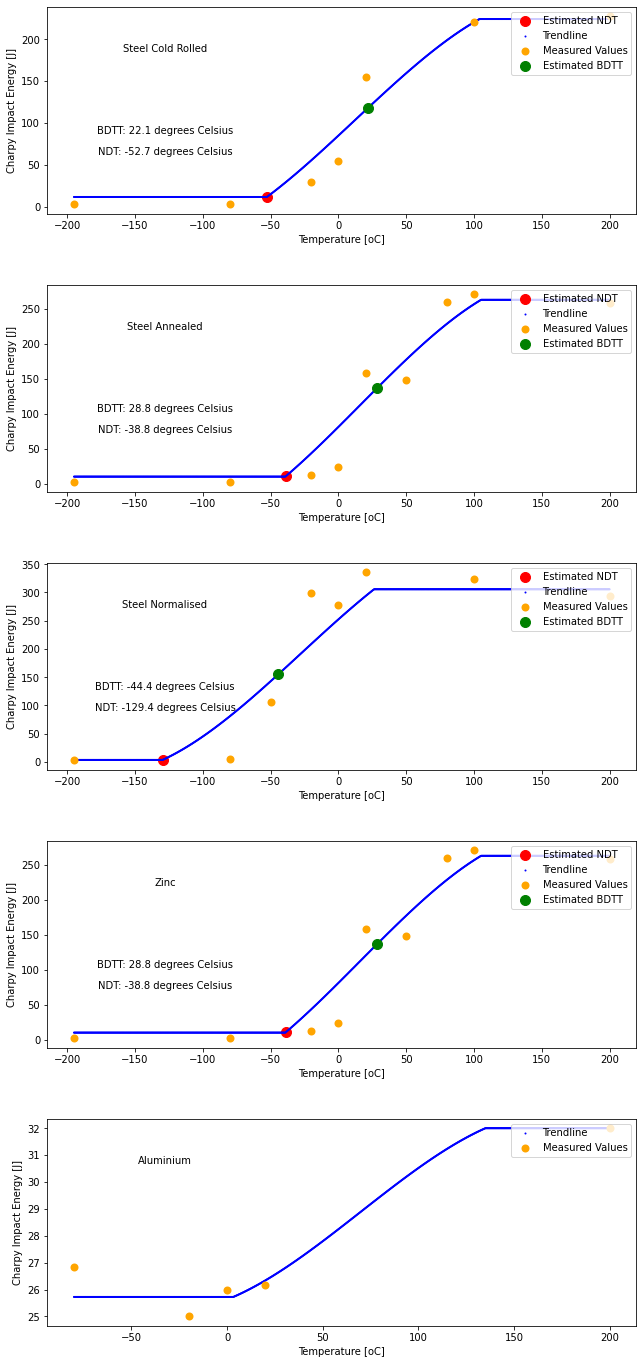

In [151]:
fig, axs = plt.subplots(5, 1, figsize=(10,20))
fig.tight_layout(pad=5)
axis_index = 0
for metal in energy_dict:
    x = energy_dict[metal]['Temperature (°C)']
    y = energy_dict[metal]['Average (J)']

    if metal == 'Aluminium':
        plot_graphs(x,y,True, axis_index, True)
    else:
        plot_graphs(x,y,True, axis_index, False)
    axs[axis_index].set(xlabel='Temperature [oC]', ylabel='Charpy Impact Energy [J]')
    axs[axis_index].text(0.2, 0.8, f'{metal}', horizontalalignment='center', verticalalignment='center', transform=axs[axis_index].transAxes)
    axis_index += 1
plt.show()

# Hardness

In [113]:
def average(lst):
    return np.round(sum(lst) / len(lst),0)

def error(lst):
    return np.round((max(lst) - min(lst)) / 2,0)

hardness_values = [[162.7, 148.5], [110.3, 106.8], [127.4, 135.5]]
diameter_values = np.array([0.01, 0.04, 0.03])
processed_diameter = 1 / np.sqrt(diameter_values)

labels = ['Steel Cold Rolled', 'Steel Annealed', 'Steel Normalised']

hardness_dict = {labels[i]: {'Values': hardness_values[i], 'Average Hardness': average(hardness_values[i]), 'Error in Hardness': error(hardness_values[i]), 'Processed Diameter': processed_diameter[i]} for i in range(3)}

hardness_dict

{'Steel Cold Rolled': {'Values': [162.7, 148.5],
  'Average Hardness': 156.0,
  'Error in Hardness': 7.0,
  'Processed Diameter': 10.0},
 'Steel Annealed': {'Values': [110.3, 106.8],
  'Average Hardness': 109.0,
  'Error in Hardness': 2.0,
  'Processed Diameter': 5.0},
 'Steel Normalised': {'Values': [127.4, 135.5],
  'Average Hardness': 131.0,
  'Error in Hardness': 4.0,
  'Processed Diameter': 5.773502691896257}}

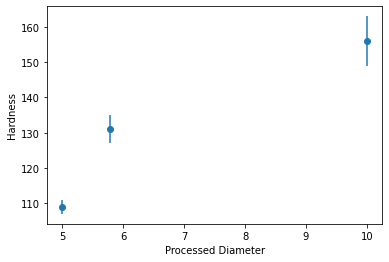

In [123]:
x = [hardness_dict[metal]['Processed Diameter'] for metal in hardness_dict]
y = [hardness_dict[metal]['Average Hardness'] for metal in hardness_dict]
hardness_errors_list = [hardness_dict[metal]['Error in Hardness'] for metal in hardness_dict]
# plt.scatter(x, y)
plt.errorbar(x, y, yerr=hardness_errors_list, fmt='o')
plt.ylabel('Hardness')
plt.xlabel('Processed Diameter')
plt.show()